# Data Preprocessing final

In [2]:
# ============================================================
# 📘 Compute Comprehensive Color Features for Conjunctiva Images
# Author: Ashwin Nagarwal
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# --------------------------------------------
# 🔧 CONFIGURATION
# --------------------------------------------
BASE_PATH = r"C:\Users\ASHWIN\Desktop\BTP\dataset anemia"
OUTPUT_CSV = "Color_Features.csv"


# --------------------------------------------
# 🧩 Helper Function
# --------------------------------------------
def compute_color_features(image_path):
    """Compute multiple color-based features for a conjunctiva image."""

    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None

    # Convert 16-bit to 8-bit if needed
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)

    # Handle alpha or white background
    if img.shape[-1] == 4:
        b, g, r, a = cv2.split(img)
        rgb = cv2.merge((r, g, b))

        if np.all(a == 255):  # White background,Alpha not meaningful(Italy)
            mask = np.any(rgb < 250, axis=2)  # non-white region
        else:
            mask = a > 0      # Real transparency(India)

    # No alpha channel present
    else:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.any(rgb < 250, axis=2)
        print(f'no alpha in {image_path}')

    valid_pixels = rgb[mask]
    if valid_pixels.size == 0:
        return None

    # --- Compute base means ---
    R_mean, G_mean, B_mean = np.mean(valid_pixels, axis=0)

    # --- Convert to HSV and LAB ---
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

    H_mean = np.mean(hsv[:, :, 0][mask])
    S_mean = np.mean(hsv[:, :, 1][mask])
    L_mean = np.mean(lab[:, :, 0][mask])
    a_mean = np.mean(lab[:, :, 1][mask])

    # --- Derived color features ---
    RG_ratio = R_mean / (G_mean + 1e-6)
    Redness_index = (R_mean - G_mean) / (R_mean + G_mean + 1e-6)
    Pallor_index = (G_mean + B_mean) / (2 * R_mean + 1e-6)
    Color_intensity = np.sqrt(R_mean**2 + G_mean**2 + B_mean**2)

    return {
        "R_mean": R_mean,
        "G_mean": G_mean,
        "B_mean": B_mean,
        "R/G_Ratio": RG_ratio,
        "Redness_Index": Redness_index,
        "Pallor_Index": Pallor_index,
        "Saturation_Mean": S_mean,
        "Hue_Mean": H_mean,
        "L_Mean": L_mean,
        "a_Mean": a_mean,
        "Color_Intensity": Color_intensity
    }


# --------------------------------------------
# 🚀 MAIN LOOP
# --------------------------------------------
results = []

for region in ["India", "Italy"]:
    region_path = os.path.join(BASE_PATH, region)
    if not os.path.exists(region_path):
        print(f"⚠️ Folder not found: {region_path}")
        continue

    patient_folders = sorted([f for f in os.listdir(region_path) if f.isdigit()], key=int)

    for patient_folder in tqdm(patient_folders, desc=f"Processing {region}"):
        folder_path = os.path.join(region_path, patient_folder)
        if not os.path.isdir(folder_path):
            continue

        # Look for forniceal_palpebral image
        target_img = None
        for file in os.listdir(folder_path):
            if "forniceal_palpebral" in file.lower() and file.lower().endswith((".png", ".jpg", ".jpeg")):
                target_img = os.path.join(folder_path, file)
                break

        if not target_img:
            continue

        features = compute_color_features(target_img)
        if features:
            features.update({
                "Region": region,
                "PatientID": patient_folder
            })
            results.append(features)


# --------------------------------------------
# 💾 SAVE RESULTS
# --------------------------------------------
df = pd.DataFrame(results)
df = df[
    [
        "Region", "PatientID", "R_mean", "G_mean", "B_mean",
        "R/G_Ratio", "Redness_Index", "Pallor_Index",
        "Saturation_Mean", "Hue_Mean", "L_Mean", "a_Mean", "Color_Intensity"
    ]
]
df.to_csv(OUTPUT_CSV, index=False)

print("\n✅ Comprehensive color feature extraction completed successfully!")
print(f"📁 Results saved to: {OUTPUT_CSV}")
print(df.head())


Processing Italy:  12%|███████▋                                                       | 15/123 [00:00<00:02, 42.09it/s]

no alpha in C:\Users\ASHWIN\Desktop\BTP\dataset anemia\Italy\9\009_forniceal_palpebral.png


Processing Italy: 100%|██████████████████████████████████████████████████████████████| 123/123 [00:02<00:00, 48.43it/s]


✅ Comprehensive color feature extraction completed successfully!
📁 Results saved to: Color_Features.csv
  Region PatientID      R_mean      G_mean      B_mean  R/G_Ratio  \
0  India         1  165.671001   82.363413  117.192178   2.011463   
1  India         2   90.111706   39.197723   69.135331   2.298901   
2  India         3  142.351378   81.646900  110.478133   1.743500   
3  India         4  172.262919  132.076020  168.121554   1.304271   
4  India         5  152.462053   82.775454  113.868232   1.841875   

   Redness_Index  Pallor_Index  Saturation_Mean    Hue_Mean      L_Mean  \
0       0.335871      0.602265       130.235266  166.364342  118.558565   
1       0.393738      0.601104       151.955653  161.561739   61.244993   
2       0.271004      0.674827       112.084268  164.514075  108.954101   
3       0.132047      0.871335        70.977456  150.275444  153.041986   
4       0.296239      0.644894       118.748946  165.379458  113.131024   

       a_Mean  Color_Intensit

In [12]:
import os
import pandas as pd

# --------------------------------------------
# 🔧 CONFIGURATION
# --------------------------------------------
BASE_PATH = r"C:\Users\ASHWIN\Desktop\BTP\dataset anemia"
FEATURES_CSV = "Color_Features.csv"   # 👈 same folder as your script
OUTPUT_CSV = "Color_Features_With_Metadata.csv"  # 👈 same folder as your script

# --------------------------------------------
# 📖 LOAD MAIN FEATURE FILE
# --------------------------------------------
df_features = pd.read_csv(FEATURES_CSV)
df_features["PatientID"] = df_features["PatientID"].astype(str)
df_features["Region"] = df_features["Region"].astype(str).str.strip()

merged_list = []

# --------------------------------------------
# 🔁 MERGE PER REGION (India, Italy)
# --------------------------------------------
for region in ["India", "Italy"]:
    meta_path = os.path.join(BASE_PATH, region, f"{region}.xlsx")

    if not os.path.exists(meta_path):
        print(f"⚠️ Metadata Excel not found for {region}, skipping.")
        continue

    # Read metadata Excel
    df_meta = pd.read_excel(meta_path)
    df_meta.rename(columns=lambda x: x.strip(), inplace=True)

    # Ensure consistent type
    df_meta["Number"] = df_meta["Number"].astype(str)

    # Select only matching region
    df_region = df_features[df_features["Region"].str.lower() == region.lower()]

    # Merge on PatientID ↔ Number
    merged = pd.merge(df_region, df_meta, left_on="PatientID", right_on="Number", how="left")

    # Drop redundant "Number" column
    merged.drop(columns=["Number"], inplace=True, errors="ignore")

    merged_list.append(merged)

# --------------------------------------------
# 🧩 COMBINE + SAVE FINAL RESULT
# --------------------------------------------
if merged_list:
    df_final = pd.concat(merged_list, ignore_index=True)
    df_final.to_csv(OUTPUT_CSV, index=False)

    print("\n✅ Successfully merged features with metadata!")
    print(f"📁 Final CSV saved to: {OUTPUT_CSV}")
    print(df_final.head())
else:
    print("❌ No merged data found. Check folder structure or Excel column names.")



✅ Successfully merged features with metadata!
📁 Final CSV saved to: Color_Features_With_Metadata.csv
  Region PatientID      R_mean      G_mean      B_mean  R/G_Ratio  \
0  India         1  165.671001   82.363413  117.192178   2.011463   
1  India         2   90.111706   39.197723   69.135331   2.298901   
2  India         3  142.351378   81.646900  110.478133   1.743500   
3  India         4  172.262919  132.076020  168.121554   1.304271   
4  India         5  152.462053   82.775454  113.868232   1.841875   

   Redness_Index  Pallor_Index  Saturation_Mean    Hue_Mean      L_Mean  \
0       0.335871      0.602265       130.235266  166.364342  118.558565   
1       0.393738      0.601104       151.955653  161.561739   61.244993   
2       0.271004      0.674827       112.084268  164.514075  108.954101   
3       0.132047      0.871335        70.977456  150.275444  153.041986   
4       0.296239      0.644894       118.748946  165.379458  113.131024   

       a_Mean  Color_Intensity  

In [16]:
import pandas as pd

# Paths
INPUT_CSV = "Color_Features_With_Metadata.csv"
OUTPUT_CSV = "Color_Features_with_anaemic_or_not.csv"

# Load CSV
df = pd.read_csv(INPUT_CSV)

# Convert Hgb column to numeric, coerce errors to NaN
df['Hgb'] = pd.to_numeric(df['Hgb'], errors='coerce')

# Hb thresholds
thresholds = {
    'M': 12.0,  # Male
    'F': 11.0   # Female
}

# Determine anaemia
def is_anaemic(row):
    gender = row['Gender']
    hgb = row['Hgb']
    if pd.isna(hgb):
        return None  # if Hgb missing or invalid
    if gender in thresholds:
        return 1 if hgb < thresholds[gender] else 0
    else:
        return None  # if gender missing or invalid

df['Anaemic'] = df.apply(is_anaemic, axis=1)

# Save updated CSV
df.to_csv(OUTPUT_CSV, index=False)

print("Updated CSV saved with 'Anaemic' column.")


Updated CSV saved with 'Anaemic' column.


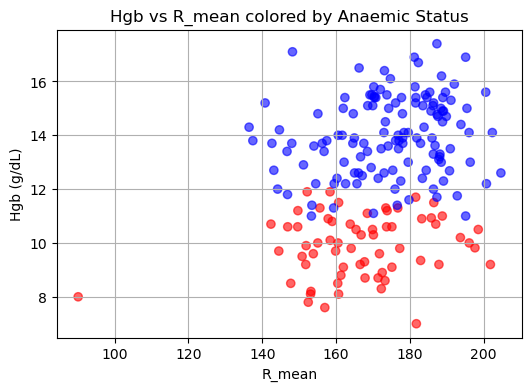

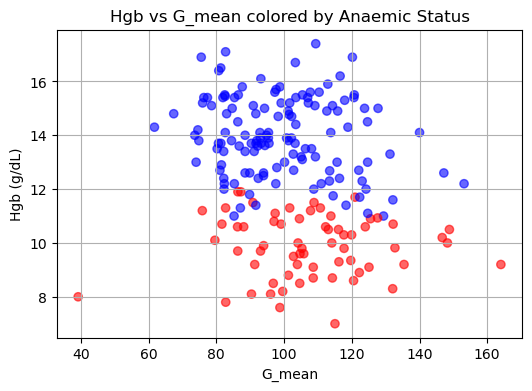

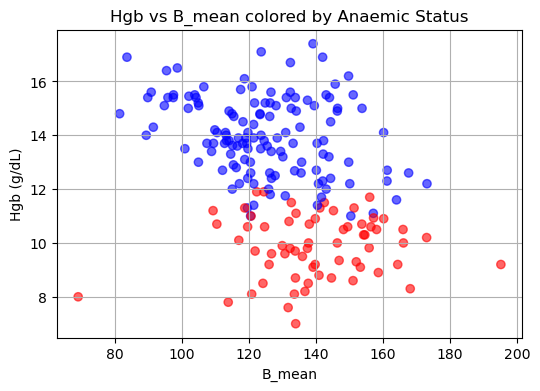

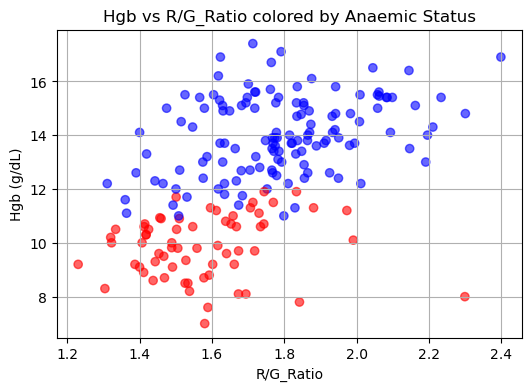

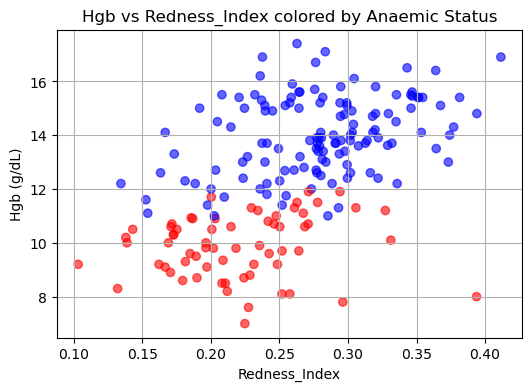

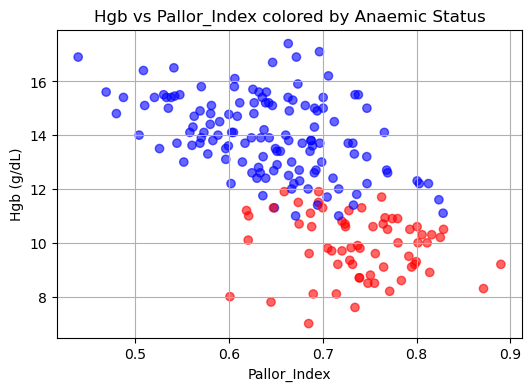

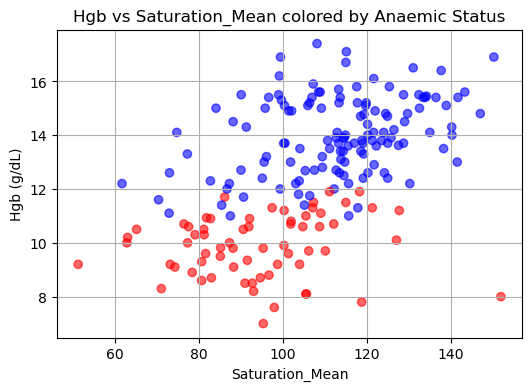

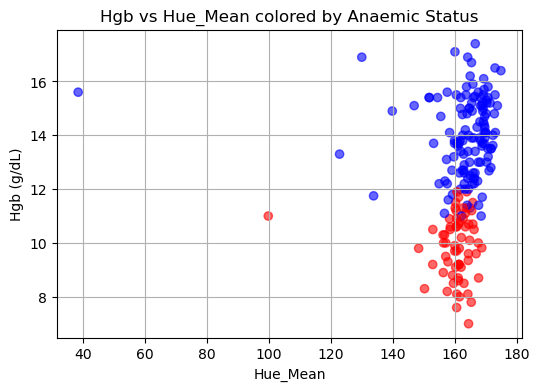

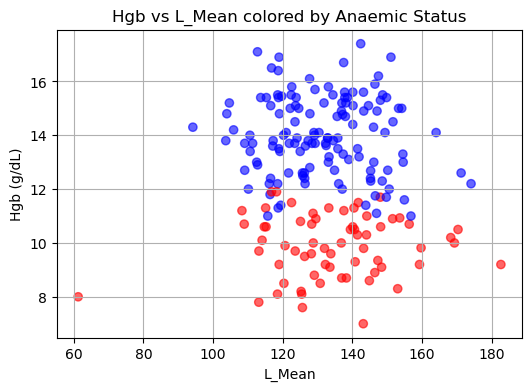

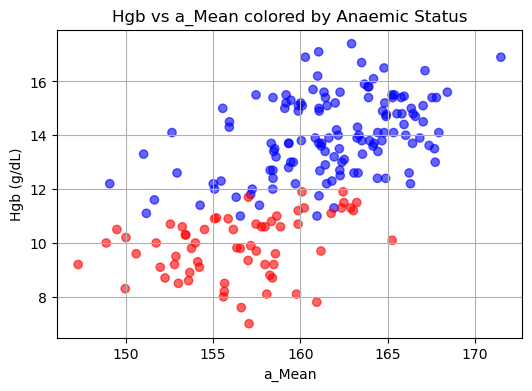

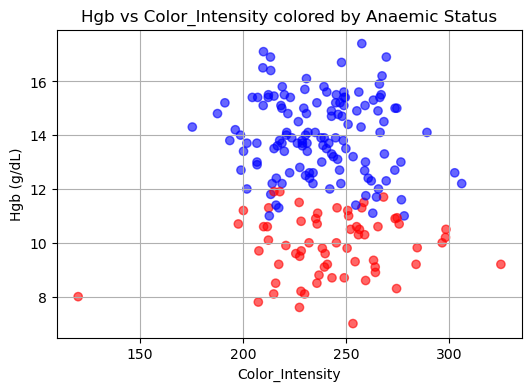

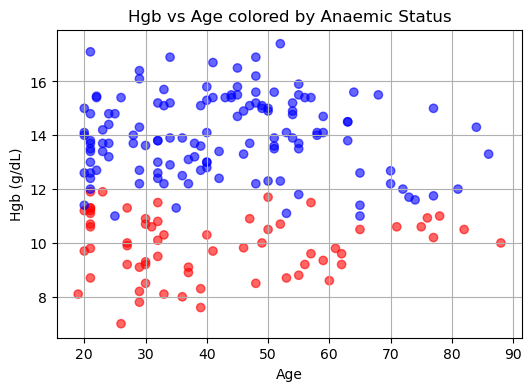

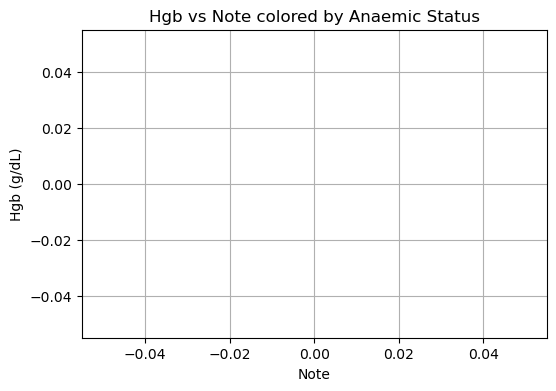

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
df = pd.read_csv("Color_Features_with_anaemic_or_not.csv")

# Drop rows where Anaemic or Hgb is NaN
df = df.dropna(subset=['Anaemic', 'Hgb'])

# Ensure Anaemic is integer
df['Anaemic'] = df['Anaemic'].astype(int)

# List of features to plot
feature_cols = [col for col in df.columns if col not in ['Gender', 'Hgb', 'Anaemic','Region','PatientID']]

# Color map: Anaemic=red, Not Anaemic=blue
color_map = {1: 'red', 0: 'blue'}

# Scatter plot for each feature vs Hgb
for feature in feature_cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[feature].to_numpy(), df['Hgb'].to_numpy(), 
                c=df['Anaemic'].map(color_map).to_numpy(), alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel('Hgb (g/dL)')
    plt.title(f'Hgb vs {feature} colored by Anaemic Status')
    plt.grid(True)
    plt.show()


# Preprocessing

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --------------------------------------------
# 🔧 CONFIGURATION
# --------------------------------------------
BASE_PATH = r"C:\Users\ASHWIN\Desktop\BTP\dataset anemia"
OUTPUT_PATH = r"C:\Users\ASHWIN\Desktop\BTP\dataset_anemia_preprocessed"

# Create output directories if not exist
os.makedirs(os.path.join(OUTPUT_PATH, "India"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "Italy"), exist_ok=True)

# --------------------------------------------
# 🧩 Morphological Opening Function
# --------------------------------------------
def apply_morph_opening(image_path):
    """Perform morphological opening on mask + output final RGB (no alpha)."""

    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None

    # Convert 16-bit → 8-bit
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)

    # --- Handle RGB, RGBA, 16-bit PNG, or JPG ---
    if img.shape[-1] == 4:
        b, g, r, a = cv2.split(img)
        rgb = cv2.merge((r, g, b))

        if np.all(a == 255):
            # Italy: alpha meaningless, white background
            mask = np.any(rgb < 250, axis=2).astype(np.uint8) * 255
        else:
            # India: real transparency
            mask = (a > 0).astype(np.uint8) * 255

    else:
        # No alpha channel (JPG etc.)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.any(rgb < 250, axis=2).astype(np.uint8) * 255

    # ---------------- Morphological Opening on mask ----------------
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # ---------------- Use mask to keep only foreground ----------------
    out_rgb = rgb.copy()
    for c in range(3):
        out_rgb[:, :, c] = np.where(opened_mask > 0, rgb[:, :, c], 255)  # white background
    
    # Convert RGB → BGR for OpenCV saving
    out_bgr = cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR)
    
    return out_bgr  # BGR only

# --------------------------------------------
# 🚀 MAIN LOOP
# --------------------------------------------
for region in ["India", "Italy"]:
    region_path = os.path.join(BASE_PATH, region)
    output_region = os.path.join(OUTPUT_PATH, region)
    os.makedirs(output_region, exist_ok=True)

    patient_folders = sorted(
        [f for f in os.listdir(region_path) if f.isdigit()],
        key=int
    )

    counter = 1
    print(f"\n🔄 Processing {region}...")
    for patient_folder in tqdm(patient_folders, desc=f"{region} Patients"):
        folder_path = os.path.join(region_path, patient_folder)
        if not os.path.isdir(folder_path):
            continue
    
        found_fp = False   # 🔹 Track if forniceal_palpebral found
    
        # Look for 'forniceal_palpebral' image
        for file in os.listdir(folder_path):
            if "forniceal_palpebral" in file.lower() and file.lower().endswith((".png", ".jpg", ".jpeg")):
                found_fp = True   # Found!
                img_path = os.path.join(folder_path, file)
                processed_img = apply_morph_opening(img_path)
                if processed_img is not None:
                    suffix = "in" if region == "India" else "it"
                    save_path = os.path.join(output_region, f"forniceal_palpebral_{suffix}_{counter}.png")
                    cv2.imwrite(save_path, processed_img)
                    counter += 1
                break  # process only the first match in this folder
    
        # 🔹 Print if no image found in this folder
        if not found_fp:
            print(f"⚠️ No forniceal_palpebral image found in {patient_folder}")
            counter += 1

print("\n✅ Morphological opening preprocessing completed successfully!")
print(f"📁 Processed dataset saved at: {OUTPUT_PATH}")



🔄 Processing India...


India Patients: 100%|██████████████████████████████████████████████████████████████████| 95/95 [00:09<00:00,  9.63it/s]



🔄 Processing Italy...


Italy Patients:   2%|█                                                                 | 2/123 [00:00<00:08, 14.16it/s]

⚠️ No forniceal_palpebral image found in 1


Italy Patients:  29%|███████████████████                                              | 36/123 [00:04<00:08, 10.40it/s]

⚠️ No forniceal_palpebral image found in 35


Italy Patients:  45%|█████████████████████████████                                    | 55/123 [00:06<00:05, 11.72it/s]

⚠️ No forniceal_palpebral image found in 54


Italy Patients:  48%|███████████████████████████████▏                                 | 59/123 [00:06<00:05, 12.46it/s]

⚠️ No forniceal_palpebral image found in 58


Italy Patients:  62%|████████████████████████████████████████▏                        | 76/123 [00:08<00:04, 11.53it/s]

⚠️ No forniceal_palpebral image found in 75


Italy Patients:  78%|██████████████████████████████████████████████████▋              | 96/123 [00:10<00:02, 11.57it/s]

⚠️ No forniceal_palpebral image found in 95


Italy Patients:  89%|█████████████████████████████████████████████████████████▏      | 110/123 [00:12<00:01, 11.84it/s]

⚠️ No forniceal_palpebral image found in 109


Italy Patients: 100%|████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  9.23it/s]


✅ Morphological opening preprocessing completed successfully!
📁 Processed dataset saved at: C:\Users\ASHWIN\Desktop\BTP\dataset_anemia_preprocessed
